Mounted at /content/gdrive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 127MB/s]


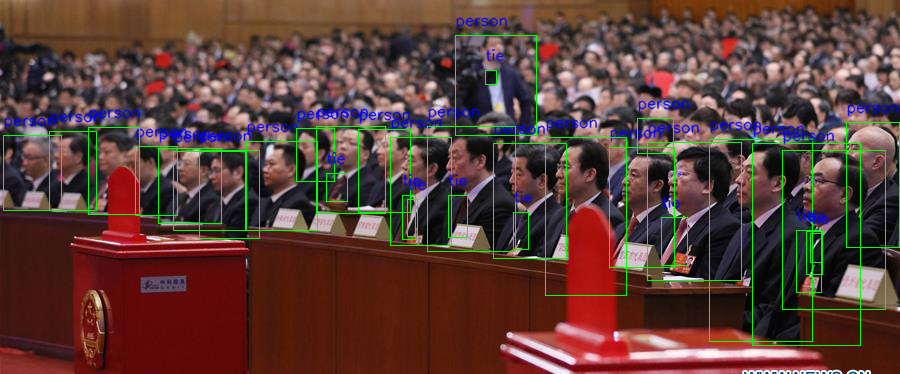

In [1]:
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Load the pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define the path to the image in your Google Drive
image_path = '/content/gdrive/MyDrive/ RCNN/ Images/ Train/jhu_crowd_v2.0/test/images/0006.jpg'

# Transform the image to a tensor
transform = T.ToTensor()
img = transform(Image.open(image_path))

# Perform inference
with torch.no_grad():
    pred = model([img])

# Extract bounding boxes, labels, and scores
bboxes, labels, scores = pred[0]["boxes"], pred[0]["labels"], pred[0]["scores"]

# Filter detections with high scores
num = torch.argwhere(scores > 0.5).shape[0]

# List of COCO class names
coco_names = ["person" , "bicycle" , "car" , "motorcycle" , "airplane" , "bus" , "train" , "truck" , "boat" , "traffic light" , "fire hydrant" , "street sign" , "stop sign" , "parking meter" , "bench" , "bird" , "cat" , "dog" , "horse" , "sheep" , "cow" , "elephant" , "bear" , "zebra" , "giraffe" , "hat" , "backpack" , "umbrella" , "shoe" , "eye glasses" , "handbag" , "tie" , "suitcase" ,
"frisbee" , "skis" , "snowboard" , "sports ball" , "kite" , "baseball bat" ,
"baseball glove" , "skateboard" , "surfboard" , "tennis racket" , "bottle" ,
"plate" , "wine glass" , "cup" , "fork" , "knife" , "spoon" , "bowl" ,
"banana" , "apple" , "sandwich" , "orange" , "broccoli" , "carrot" , "hot dog" ,
"pizza" , "donut" , "cake" , "chair" , "couch" , "potted plant" , "bed" ,
"mirror" , "dining table" , "window" , "desk" , "toilet" , "door" , "tv" ,
"laptop" , "mouse" , "remote" , "keyboard" , "cell phone" , "microwave" ,
"oven" , "toaster" , "sink" , "refrigerator" , "blender" , "book" ,
"clock" , "vase" , "scissors" , "teddy bear" , "hair drier" , "toothbrush" , "hair brush"] # Truncated for brevity

# Initialize font for text overlay
font = cv2.FONT_HERSHEY_SIMPLEX

# Read the image for visualization
igg = cv2.imread(image_path)

# Draw bounding boxes and labels
for i in range(num):
    x1, y1, x2, y2 = bboxes[i].numpy().astype("int")
    class_name = coco_names[labels.numpy()[i] - 1]
    igg = cv2.rectangle(igg, (x1, y1), (x2, y2), (0, 255, 0), 1)
    igg = cv2.putText(igg, class_name, (x1, y1 - 10), font, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

# Display the result
cv2_imshow(igg)


In [ ]:
import os
project_path = '/content/drive/MyDrive/rcnn'
model_save_path = os.path.join(project_path, 'my_model', 'fast_rcnn_model.pth')
torch.save(model.state_dict(), model_save_path)

# New section

# New section

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [ ]:
!pip install -U torchvision # We need a new versino of torchvision for this project

In [ ]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO

In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
drive.mount('/content/gdrive')

NameError: name 'drive' is not defined

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [ ]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [ ]:
dataset_path = " /content/gdrive/MyDrive/ RCNN/mall_dataset "

In [ ]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

In [ ]:
!ls  /content/gdrive/MyDrive/ RCNN/mall_dataset/train

In [ ]:
image = cv2.imread(os.path.join(train_dataset.root, train_dataset.split))

In [ ]:
len(train_dataset)

117266

In [ ]:
 # Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

# New section

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = [224, 224]

train_path = '  /content/drive/MyDrive/ RCNN/UCSD_Anomaly_Dataset.v1p2/UCSDped1'
valid_path = '/content/drive/MyDrive/ RCNN/UCSD_Anomaly_Dataset.v1p2/UCSDped2'
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/ RCNN/UCSD_Anomaly_Dataset.v1p2/UCSDped1 ')
# our layers - you can add more if you want
x = Flatten()(resnet.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)
# view the structure of the model
model.summary()

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/ RCNN/UCSD_Anomaly_Dataset.v1p2/UCSDped1',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 16002 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/ RCNN/UCSD_Anomaly_Dataset.v1p2/UCSDped2',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode ='categorical')

Found 6570 images belonging to 2 classes.


In [ ]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=16,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/16


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 2), output.shape=(None, 0)